In [106]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [107]:
df=pd.read_csv("data.csv", encoding='latin-1', sep=";")

EDA trong chuỗi thời gian

In [108]:
data=df.iloc[:, [0,2151091405 % 16 + 1, 2151091405 % 16 +2, 2151091405 % 16 +3]]
data.head()

,Ngày,14,15,16
0,01/01/2021,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4
3,01/04/2021,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ngày    365 non-null    object 
 1   14      365 non-null    float64
 2   15      365 non-null    float64
 3   16      365 non-null    float64
dtypes: float64(3), object(1)
memory usage: 11.5+ KB


In [110]:
print(data.describe())

                14           15           16
count   365.000000   365.000000   365.000000
mean   1040.314521  1040.321918  1040.326301
std     105.145787   105.144258   105.143470
min     885.700000   885.600000   885.600000
25%     988.400000   988.400000   988.400000
50%    1022.600000  1022.600000  1022.600000
75%    1061.600000  1061.600000  1061.600000
max    1565.500000  1565.500000  1565.500000


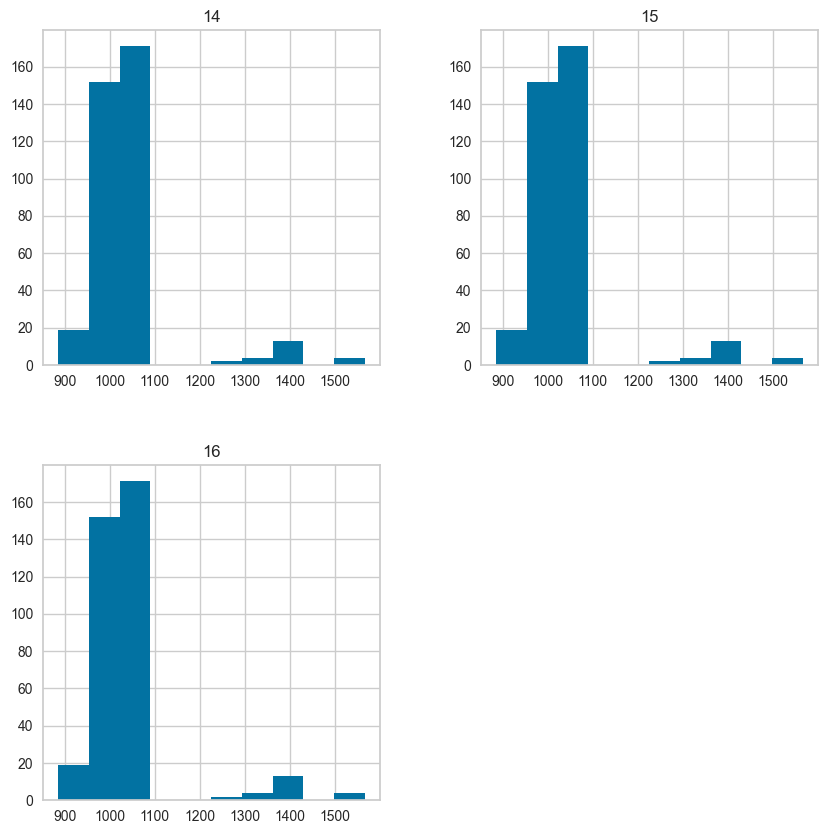

In [111]:
# Kiểm tra phân bố của các biến số
data.hist(figsize=(10,10))
plt.show()

In [112]:
# Chuyển đổi cột 'date' sang datetime
data['Ngày'] = pd.to_datetime(data['Ngày'], format='%d/%m/%Y')

# Trích xuất ngày, tháng, năm
data['day'] = data['Ngày'].dt.day
data['month'] = data['Ngày'].dt.month
data['year'] = data['Ngày'].dt.year

# Chuyển đổi sang định dạng số float nếu cần thiết
data['day'] = data['day'].astype(float)
data['month'] = data['month'].astype(float)
data['year'] = data['year'].astype(float)

In [113]:
# Phân tích mối quan hệ giữa các biến
correlation = data.corr()
print(correlation)

           Ngày        14        15        16       day     month  year
Ngày   1.000000  0.152387  0.152380  0.152385  0.095131  0.996504   NaN
14     0.152387  1.000000  1.000000  1.000000  0.097096  0.146286   NaN
15     0.152380  1.000000  1.000000  1.000000  0.097114  0.146277   NaN
16     0.152385  1.000000  1.000000  1.000000  0.097133  0.146280   NaN
day    0.095131  0.097096  0.097114  0.097133  1.000000  0.011893   NaN
month  0.996504  0.146286  0.146277  0.146280  0.011893  1.000000   NaN
year        NaN       NaN       NaN       NaN       NaN       NaN   NaN


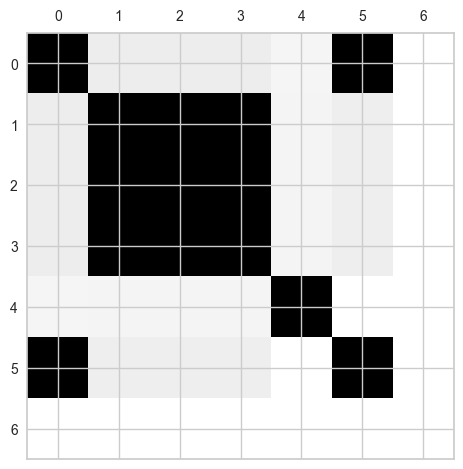

In [114]:
# Tạo biểu đồ tương quan
plt.matshow(correlation)
plt.show()

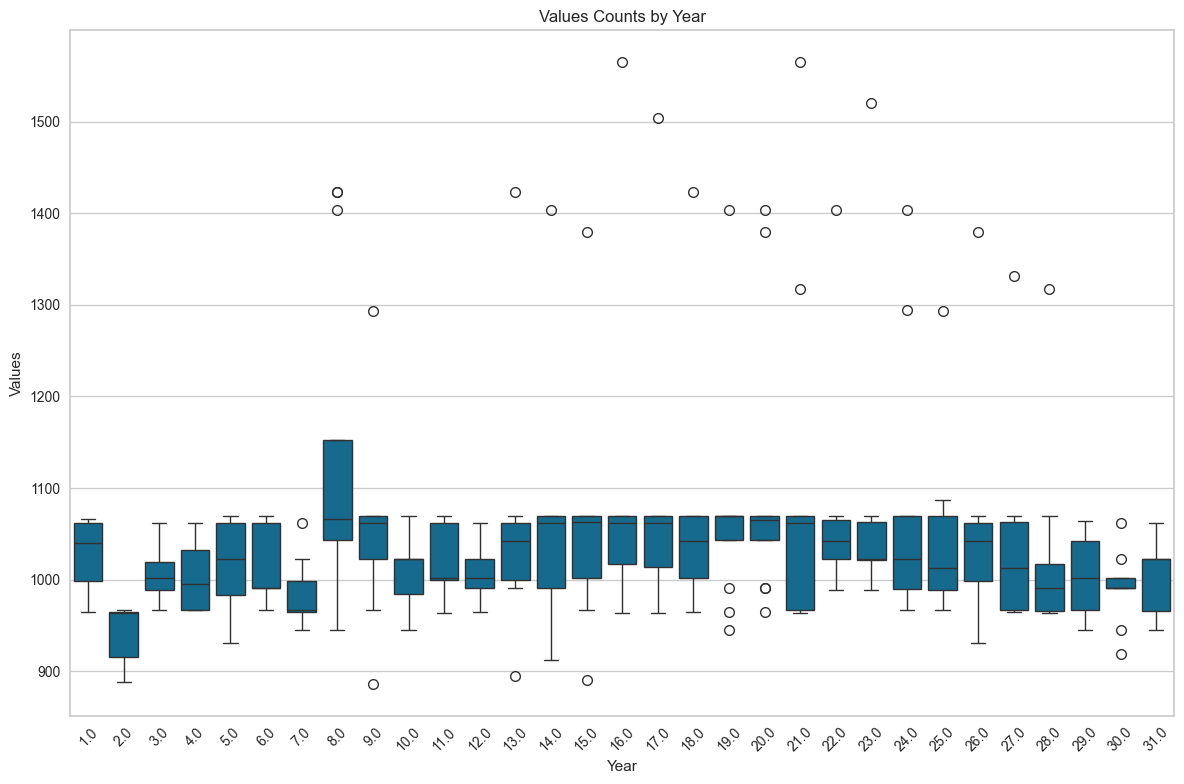

In [115]:
plt.figure(figsize=(12,8),  facecolor='white')
 
sns.boxplot(x='day', y='14', data=data)
plt.xticks(rotation=45)
plt.title('Values Counts by Year')
plt.xlabel('Year')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

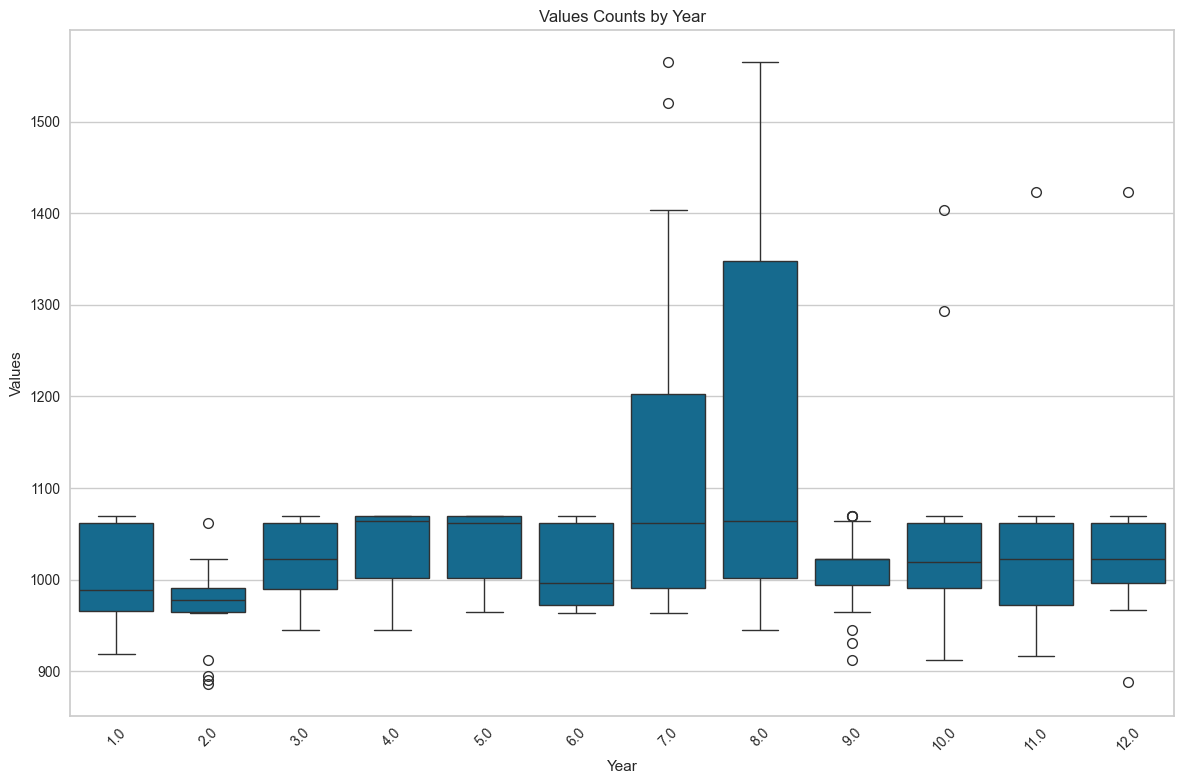

In [116]:
plt.figure(figsize=(12,8),  facecolor='white')
 
sns.boxplot(x='month', y='15', data=data)
plt.xticks(rotation=45)
plt.title('Values Counts by Year')
plt.xlabel('Year')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

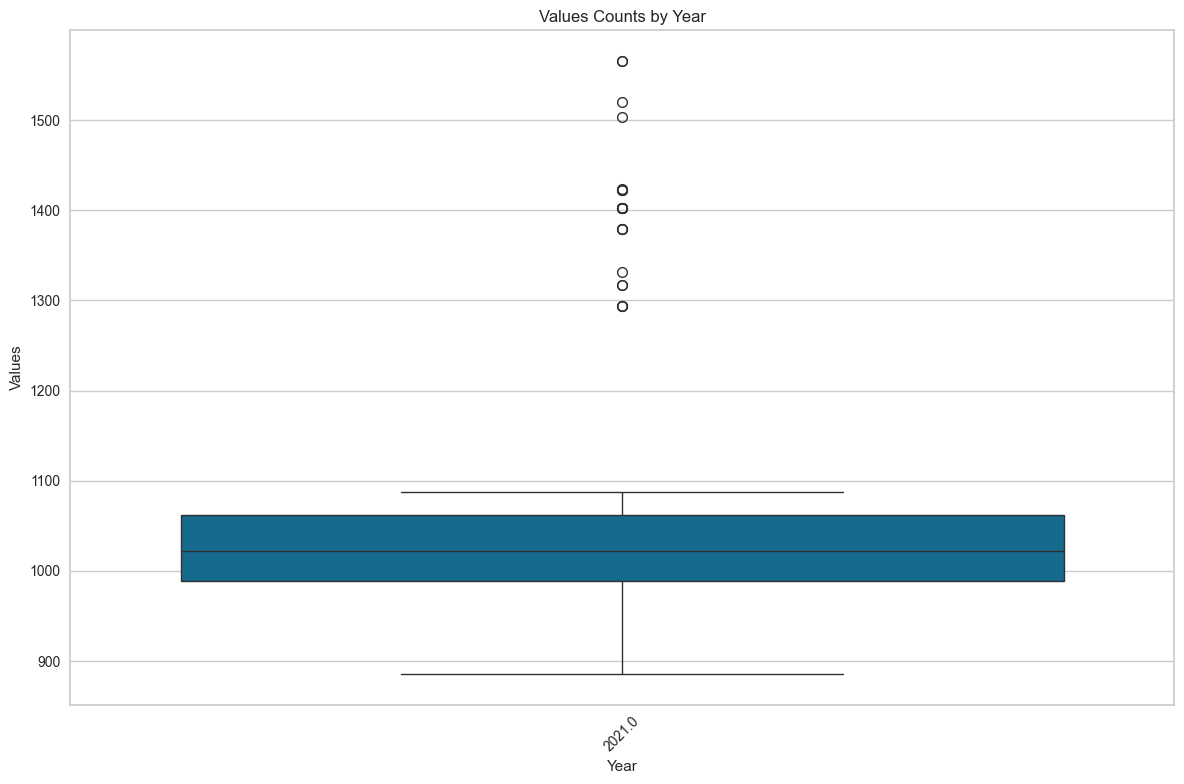

In [117]:
plt.figure(figsize=(12,8),  facecolor='white')
 
sns.boxplot(x='year', y='16', data=data)
plt.xticks(rotation=45)
plt.title('Values Counts by Year')
plt.xlabel('Year')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

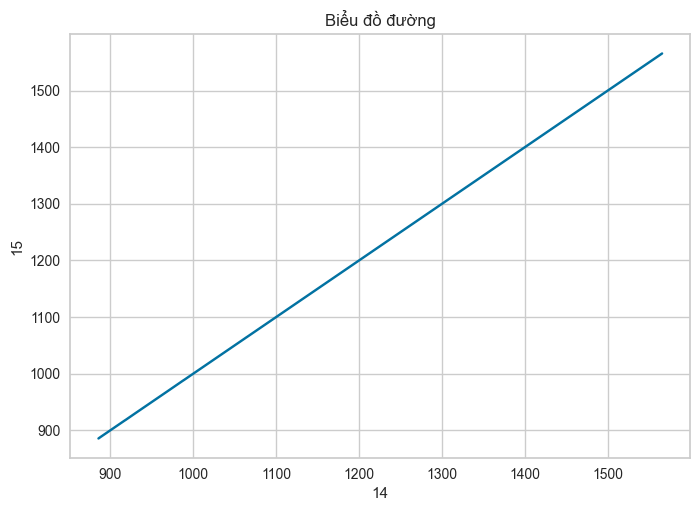

In [118]:
# Tạo biểu đồ Đường
days1='14'
days2='15'
days3='16'
sns.lineplot(
    x = days1,
    y = days2,
    data=data
)
plt.title('Biểu đồ đường')
plt.show()

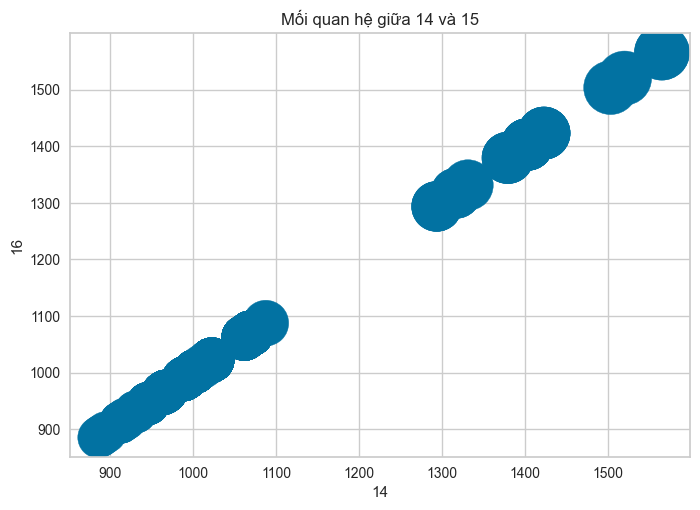

In [119]:
# Tạo biểu đồ Scatter
plt.scatter(data[days1], data[days2], data[days3])
plt.xlabel(days1)
plt.ylabel(days2)
plt.ylabel(days3)
plt.title(f'Mối quan hệ giữa {days1} và {days2}')
plt.show()

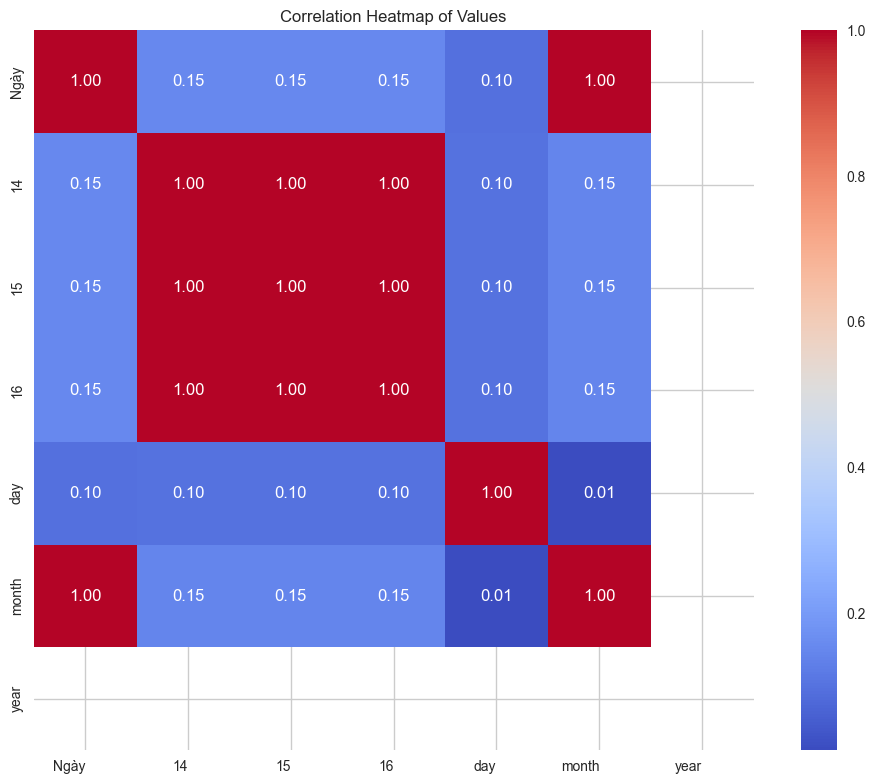

In [120]:
# Biểu đồ headmap
# Tính ma trận tương quan
corr = data.corr()

# Tạo bản đồ nhiệt
plt.figure(figsize=(10,8), facecolor='white')
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Values')
plt.xticks( ha='right')
plt.yticks()
plt.tight_layout()
plt.show()

KALMAN

In [121]:
time_series = df.iloc[:,2151091405 % 16 + 1]
time_series.head()

0     964.4
1    1019.7
2     988.4
3    1010.8
4    1061.5
Name: 14, dtype: float64

Dự báo điểm tiếp theo: 1022.8350277919874


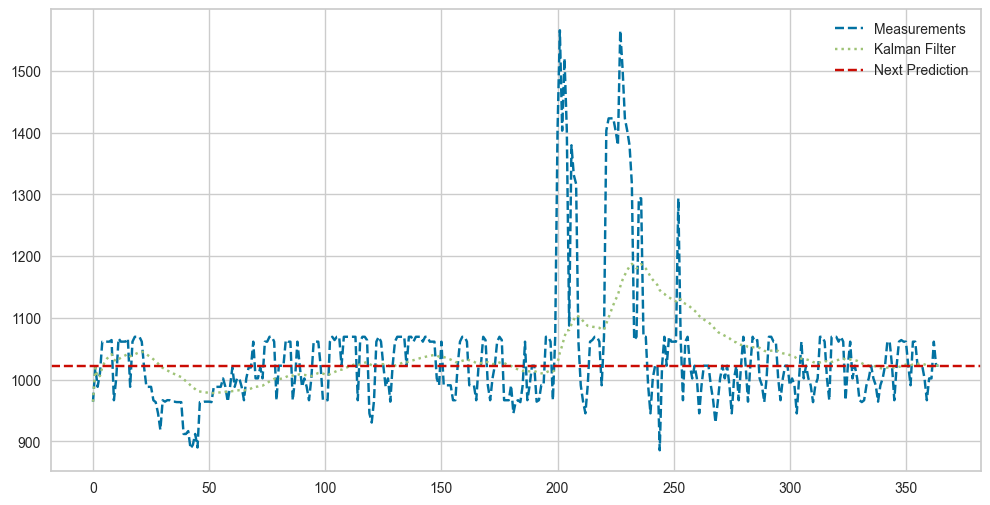

In [122]:
Q = 1e-5  # Hiệp phương sai của quá trình (process variance)
R = 0.01  # Hiệp phương sai của đo lường (measurement variance)
n_timesteps = len(time_series)
xhat = np.zeros(n_timesteps)  # Ước lượng trạng thái ban đầu (a posteri estimate of x)
P = np.zeros(n_timesteps)  # Ước lượng hiệp phương sai của lỗi (a posteri error estimate)
xhatminus = np.zeros(n_timesteps)  # Trạng thái dự đoán (a priori estimate of x)
Pminus = np.zeros(n_timesteps)  # Dự đoán hiệp phương sai của lỗi (a priori error estimate)
K = np.zeros(n_timesteps)  # Kalman gain

# Khởi tạo giá trị ban đầu
xhat[0] = time_series[0]
P[0] = 1.0

# Kalman filter
for k in range(1, n_timesteps):
    # Dự đoán (predict)
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1] + Q

    # Cập nhật (update)
    K[k] = Pminus[k] / (Pminus[k] + R)
    xhat[k] = xhatminus[k] + K[k] * (time_series[k] - xhatminus[k])
    P[k] = (1 - K[k]) * Pminus[k]

# Dự báo điểm tiếp theo
xhat_next = xhat[-1]
P_next = P[-1] + Q
K_next = P_next / (P_next + R)
prediction = xhat_next

print(f'Dự báo điểm tiếp theo: {prediction}')

# Vẽ kết quả
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Measurements', linestyle='dashed')
plt.plot(xhat, label='Kalman Filter', linestyle='dotted')
plt.axhline(y=prediction, color='r', linestyle='--', label='Next Prediction')
plt.legend()
plt.show()